In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as anp
import autograd.numpy.random as npr

from autograd.scipy.integrate import odeint
from autograd import value_and_grad
from autograd.builtins import tuple
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [173]:
def permutation_energy(nums, target):
    """
    Measures the correctness of sorting via comparing:
    1. The norms of the consecutive differences btwn the results and re-sorted results (1st term)
    2. The closeness to the targets elementwise (2nd term)

    Args:
        nums (Iterable): resulting output from sorting system
        target (Iterable): Groundtruth sorted values (same size as nums)
    """
    sorted_nums = np.sort(nums)
    min_discrepancies = np.diff(sorted_nums)
    discrepancies = np.diff(nums)
    return np.abs(discrepancies-min_discrepancies).mean() + np.abs(target-nums).mean()

# Sorting ODE
----

To start, consider sorting two numbers $a, b$ in a continuous fashion, and suppose $a > b$. If our input list is $[a, b]$, we would ideally want $a$ to converge as quickly as possible to the value of $b$, and similarly $b \rightarrow a$. In other words we want to model a continuous analogue of the `swap` function to get the sorted result $[b, a]$. In code, a basic implementation of the `swap` function looks like:

```
swap(float a, float b) {
    float temp = a;
    b = a;
    a = temp;
}
```

We can derive a continuous version of this via a system of ODEs by utilizing the discrepany between $a, b$ to our advantage.

\begin{align}
    y(0) &= \gamma \\
    x_1(0) &= a \\
    x_2(0) &= b \\
    \dot{y} &= (x_1-x_2)y \\
    \dot{x_1} &= -y \\
    \dot{x_2} &= y
\end{align}

The real equation of interest is Eq. (4). The variable $y$ is a driving force which in some sense serves as a dynamical register akin to the `temp` variable in that it stores a local "state" of the system. The dynamics then undergo three stages:
1. If $x_1 > x_2$ with the values fixed, then $y$ changes exponentially in time - which we then use to quickly decrease the value of $y_1$ (Eq. (5)), and increase the value of $x_2$ (Eq.(6)). 
2. Inevitably, as the discrepancy $x_1 - x_2 \rightarrow 0$ (i.e. the trajectories cross), this implies that $y$ is constant which implies that $x_1, x_2$ continue their trajectories but at a linear rate in time.
3. When $x_1 < x_2$, $y$ will exponentially decay which in turn slows down the dynamics of $x_1, x_2$. However, there is no guarantee that $x_1, x_2$ will converge to *exactly* $b, a$ respectively. The precision of the results depends sensitively on the initial driving force $\gamma$ (as will be demonstrated below). 

Another thing to note is that $\gamma > 0$ because otherwise nothing will ever happen in the dynamics.






## Smooth bubble sort

One of the simplest sorting algorithms is bubble sort. It works by linearly scanning through an array and greedily swapping pairs of values that are out of order, also it is guaranteed to finish in $\mathcal{O}(n^2)$ iterations. We can develop a smooth version using the ODE from above. As before, we need $n$ dynamical variables for each entry in the input list (initialized to the input values), and also $n-1$ driving parameters for each pairwise discrepancy:

\begin{align*}
\dot{y_1} &= (x_1-x_2)y_1 \\
\dot{y_2} &= (x_2-x_3)y_2 \\
\vdots \\
\dot{y}_{n-1} &= (x_{n-1}-x_n)y_{n-1} \\
\dot{x_1} &= \quad\:-y_1 \\
\dot{x_2} &= y_1 - y_2 \\
\dot{x_3} &= y_2 - y_3 \\
\vdots \\
\dot{x}_{n-1} &= y_{n-2} - y_{n-1} \\
\dot{x_n} &= y_{n-1} \\
\end{align*}

Each driving parameter $y_i$ must be initialized to a non-zero value as before. For simplicity, we can initialize all of them with $\gamma$. Intuitively, the above ODEs implement a coupled neighbor swap across the whole input list i.e. for each $x_i$, the pairs $x_{i-1}, x_i$ and $x_i, x_{i+1}$ are driven into order - exactly the mechanism behind bubble sort!

In [174]:
class SortingSystem:
    """Groundtruth dynamical system for sorting
    """
    def __init__(self, n):
        self.n = n
        
    def __call__(self, _, q):
        x, y = q[:self.n], q[self.n:]
        xdot = np.r_[-y, 0] + np.r_[0, y]
        ydot = (x[:-1]-x[1:])*y
        return np.r_[xdot, ydot]
    
    def jac(self, _, q):
        """RHS jacobian, for efficiency in odeint
        """
        x, y = q[:self.n], q[self.n:]
        b1 = np.zeros((self.n, self.n))
        b2 = (-np.diag(np.ones(self.n))+np.diag(np.ones(self.n-1),k=-1))[:, :-1]
        b3 = (np.diag(np.r_[y,0]) - np.diag(y, k=1))[:-1]
        b4 = np.diag(x[:-1]-x[1:])
        return np.block([[b1, b2], [b3, b4]])
    
    def sparse_mask(self, dummy_values):
        """Jacobian sparsity mask, for efficiency in odeint
        """
        sparsity = self.jac(None, dummy_values)
        sparsity[self.n:, self.n:] = 1
        return sparsity > 0

### 1. Smooth `swap` (n=2)

In [175]:
# control parameter initial value
gamma = 0.01

n = 2
nums = np.array([2., 1.])
controls = np.ones(n-1)*gamma
init_conds = np.concatenate([nums, controls])

sorter = SortingSystem(n)

output = solve_ivp(
    sorter, 
    t_span=(0, 1000), 
    y0=init_conds, 
    method='Radau', 
    jac=sorter.jac, 
    jac_sparsity=sorter.sparse_mask(init_conds), 
)

solution = output.y[:len(nums), -1]
groundtruth = np.sort(nums)

print(f"Original list: {nums}")
print(f"Sorted list: {solution}")
print(f"Groundtruth: {groundtruth}")

Original list: [2. 1.]
Sorted list: [0.99010002 2.00989998]
Groundtruth: [1. 2.]


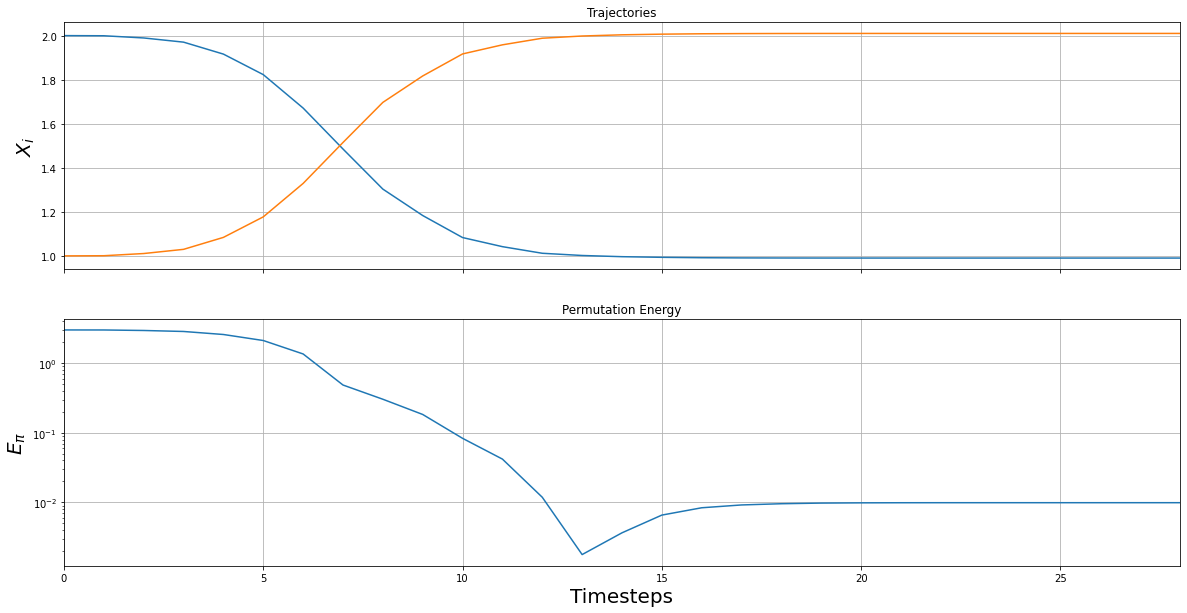

In [176]:
energies = [permutation_energy(traj, groundtruth) for traj in output.y[:len(nums)].T]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

for ax, (title, lbl), data in zip(
    axes, 
    [("Trajectories", "$X_i$"), ("Permutation Energy", "$E_\pi$")], 
    [output.y[:len(nums)].T, energies]
):
    ax.plot(data)
    ax.set_title(title)
    ax.set_xlim(0, len(output.t)-1)
    ax.set_ylabel(lbl, fontsize=20)
    ax.grid()
    if title == "Permutation Energy":
        ax.semilogy()

axes[1].set_xlabel("Timesteps", fontsize=20);

### 2. Smooth bubble sort (n > 2)

In [179]:
# control parameter initial value
gamma = 0.001

n = 30
nums = np.random.uniform(0, 15, n)
controls = np.ones(n-1)*gamma
init_conds = np.concatenate([nums, controls])

sorter = SortingSystem(n)

output = solve_ivp(
    sorter, 
    t_span=(0, 1000), 
    y0=init_conds, 
    method='Radau', 
    jac=sorter.jac, 
    jac_sparsity=sorter.sparse_mask(init_conds), 
)

solution = output.y[:len(nums), -1]
groundtruth = np.sort(nums)

print(f"Original list: {nums}")
print(f"Sorted list: {solution}")
print(f"Groundtruth: {groundtruth}")

Original list: [ 8.79446184 13.10362136 10.0695623   1.02892672  4.43207822  6.84977311
 10.17106634  7.18880143 12.57499631  6.65113212  4.68280671  6.10899668
  0.4148464   5.96647036  4.85492868 10.17132225  0.61407535  9.11093199
  0.1268124   4.49621225 14.31157421  8.91229571  6.57140349  3.91432361
  4.69914194  9.43453713 11.62174829  5.9291646   4.87220027 13.92099494]
Sorted list: [ 0.12945499  0.41472828  1.02923263  0.61248039  4.43211027  3.9136003
  4.6809561   4.49771646  4.85334806  4.6987158   4.87157212  5.96680841
  6.11099366  5.930275    6.65153308  6.85073125  6.57029555  7.18836539
  8.79399804  8.91192185  9.11028565 10.07034423  9.43434593 10.17079778
 10.17172373 11.622245   12.57204563 13.10451953 13.92109973 14.31296214]
Groundtruth: [ 0.1268124   0.4148464   0.61407535  1.02892672  3.91432361  4.43207822
  4.49621225  4.68280671  4.69914194  4.85492868  4.87220027  5.9291646
  5.96647036  6.10899668  6.57140349  6.65113212  6.84977311  7.18880143
  8.794461

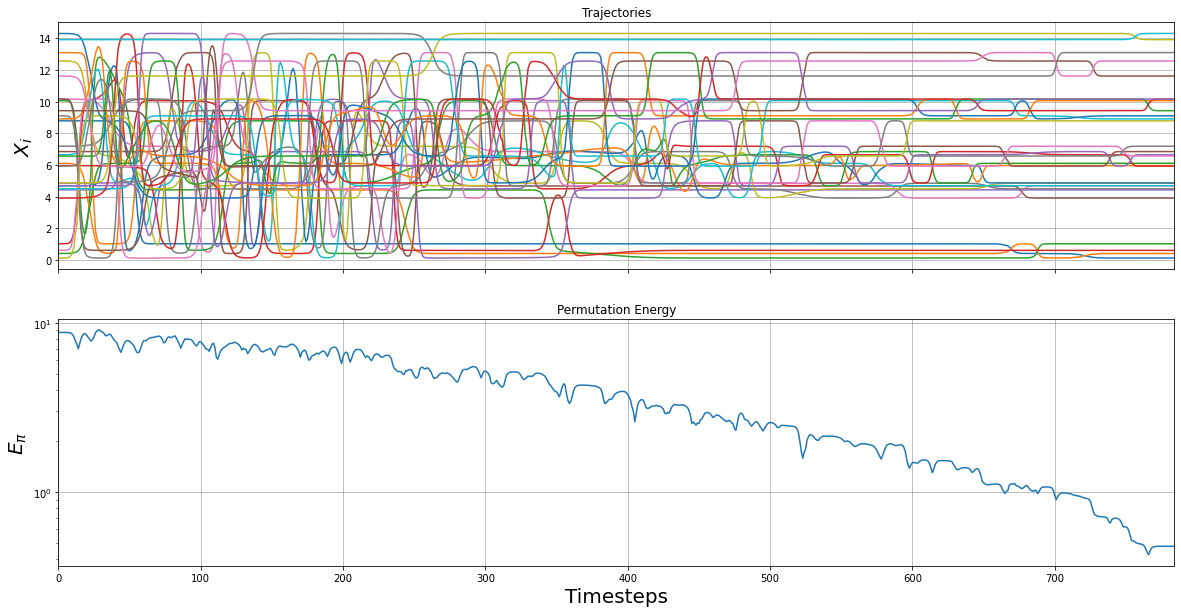

In [180]:
energies = [permutation_energy(traj, groundtruth) for traj in output.y[:n].T]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

for ax, (title, lbl), data in zip(
    axes, 
    [("Trajectories", "$X_i$"), ("Permutation Energy", "$E_\pi$")], 
    [output.y[:n].T, energies]
):
    ax.plot(data)
    ax.set_title(title)
    ax.set_xlim(0, len(output.t)-1)
    ax.set_ylabel(lbl, fontsize=20)
    ax.grid()
    if title == "Permutation Energy":
        ax.semilogy()

axes[1].set_xlabel("Timesteps", fontsize=20);

## Learning a sorting system (FAIL)

In [111]:
def polynomial_system(q, _, params):
    n = (len(q)+1)//2
    x, y = q[:n], q[n:] 
    monomials = anp.concatenate([x, y, anp.outer(x, y).flatten()])
    return anp.dot(params, monomials)


def permutation_energy(nums):
    sorted_nums = anp.sort(nums)
    min_energy = anp.linalg.norm(anp.diff(sorted_nums) + (sorted_nums[0]-sorted_nums[-1]))
    energy = anp.linalg.norm(anp.diff(nums) + (nums[0]-nums[-1]))
    return anp.abs(min_energy-energy)

    
def cost(params, func, times, init_conds, lamb=0.1):
    n = (len(init_conds)+1)//2
    inshape = len(init_conds) + n*(n-1)
    param_mat = params.reshape(len(init_conds), inshape)
    
    final_sol = odeint(
        func, 
        init_conds, 
        times, 
        tuple((param_mat,)),
        rtol=1e-4
    )[-1]
    
    l1_loss = anp.mean(anp.abs(params))
    sorting_loss = permutation_energy(final_sol)
    return sorting_loss + lamb*l1_loss

In [72]:
times = anp.linspace(0, 10, 20)

size = len(nums) + (len(nums)-1) + len(nums)*(len(nums)-1)
rand_state = npr.RandomState(0)
init_params = rand_state.randn(2*len(nums)-1, size)*anp.sqrt(size)

init_conds = anp.concatenate([
    rand_state.uniform(5, 10, len(nums)),
    anp.ones(len(nums)-1)*gamma
])

In [73]:
objective = lambda params: cost(params, polynomial_system, times, anp.array(init_conds))

# Specify gradient of objective function using autograd.
objective_with_grad = value_and_grad(objective)

result = minimize(objective_with_grad, init_params, jac=True, method='CG', options={'maxiter':25, 'disp':True})

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+02   r2 = -0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.9473684210526D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.1000000000000D+02   r2 =  0.1000000000000D+02
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9473684210526D+01   r2 = -0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.8947368421053D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.9473684210526D+01   r2 =  0.9473684210526D+01
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the mach

         Current function value: nan
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
